## Kaggle – DataTops®
Luismi ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a Luismi a mejorar ese modelo?

## Métrica: 
Error de raíz cuadrada media (RMSE) es la desviación estándar de los valores residuales (errores de predicción). Los valores residuales son una medida de la distancia de los puntos de datos de la línea de regresión; RMSE es una medida de cuál es el nivel de dispersión de estos valores residuales. En otras palabras, le indica el nivel de concentración de los datos en la línea de mejor ajuste.


$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$


## Librerías

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import urllib.request

## Datos

In [3]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df = pd.read_csv("./data/train.csv", index_col=0)
df.index.name = None

## Exploración de los datos

In [ ]:
df.info()

In [ ]:
df.head()

In [5]:
variable="Memory"

In [ ]:
df[variable].nunique()

In [ ]:
df_memory=df[variable].value_counts()

In [ ]:
df_memory

In [ ]:
df.tail()

In [ ]:
df.describe()

## Procesado de datos

Nuestro target es la columna `Price_in_euros`

In [4]:
target = df["Price_in_euros"]

In [5]:
df["inches"]=df.Inches.astype(float)
df["ram_gb"]=df["Ram"].str.replace("GB","").astype(int)
df["weight_kg"]=df["Weight"].str.replace("kg","").astype(float)
df = pd.get_dummies(df, columns=['TypeName'], prefix='Type')

In [6]:
import numpy as np
import pandas as pd

# Función para extraer el número de memoria y convertir a GB
def convert_to_gb(memory):
    # Extraemos el número de memoria, ignorando texto como 'GB', 'TB', etc.
    try:
        memory_value = ''.join([char for char in memory if char.isdigit() or char == '.'])
        memory_value = float(memory_value)
        # Si la unidad es TB, la convertimos a GB
        if 'TB' in memory:
            return memory_value * 1024  # 1 TB = 1024 GB
        else:
            return memory_value  # Si ya está en GB, lo dejamos como está
    except ValueError:
        return np.nan  # Si no se puede extraer un valor numérico, devolvemos NaN

# Función para procesar cada valor de la columna 'Memory' que pueda tener múltiples memorias
def process_memory(memory):
    ssd, hdd, flash, hybrid = 0, 0, 0, 0  # Inicializamos las variables de cada tipo de memoria

    # Separamos los valores si hay un '+'
    memories = memory.split(' + ') if isinstance(memory, str) else []
    
    for mem in memories:
        # Revisamos el tipo de memoria y aplicamos la conversión a GB
        if 'SSD' in mem:
            ssd += convert_to_gb(mem)
        elif 'HDD' in mem:
            hdd += convert_to_gb(mem)
        elif 'Flash Storage' in mem:
            flash += convert_to_gb(mem)
        elif 'Hybrid' in mem:
            hybrid += convert_to_gb(mem)

    return ssd, hdd, flash, hybrid

# Aplicamos la función para crear nuevas columnas
df[['SSD_GB', 'HDD_GB', 'Flash_Storage_GB', 'Hybrid_GB']] = df['Memory'].apply(lambda x: pd.Series(process_memory(x)))
"""
# Sumar los valores de las columnas
ssd_sum = df['SSD_GB'].sum()
hdd_sum = df['HDD_GB'].sum()
flash_storage_sum = df['Flash_Storage_GB'].sum()
hybrid_sum = df['Hybrid_GB'].sum()

# Mostrar los resultados
print(f"Suma total de SSD en GB: {ssd_sum} GB")
print(f"Suma total de HDD en GB: {hdd_sum} GB")
print(f"Suma total de Flash Storage en GB: {flash_storage_sum} GB")
print(f"Suma total de Hybrid en GB: {hybrid_sum} GB")
"""


'\n# Sumar los valores de las columnas\nssd_sum = df[\'SSD_GB\'].sum()\nhdd_sum = df[\'HDD_GB\'].sum()\nflash_storage_sum = df[\'Flash_Storage_GB\'].sum()\nhybrid_sum = df[\'Hybrid_GB\'].sum()\n\n# Mostrar los resultados\nprint(f"Suma total de SSD en GB: {ssd_sum} GB")\nprint(f"Suma total de HDD en GB: {hdd_sum} GB")\nprint(f"Suma total de Flash Storage en GB: {flash_storage_sum} GB")\nprint(f"Suma total de Hybrid en GB: {hybrid_sum} GB")\n'

-----------------------------------------------------------------------------------------------------------------

## Modelado

### 1. Definir X e y

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Company                  912 non-null    object 
 1   Product                  912 non-null    object 
 2   Inches                   912 non-null    float64
 3   ScreenResolution         912 non-null    object 
 4   Cpu                      912 non-null    object 
 5   Ram                      912 non-null    object 
 6   Memory                   912 non-null    object 
 7   Gpu                      912 non-null    object 
 8   OpSys                    912 non-null    object 
 9   Weight                   912 non-null    object 
 10  Price_in_euros           912 non-null    float64
 11  inches                   912 non-null    float64
 12  ram_gb                   912 non-null    int32  
 13  weight_kg                912 non-null    float64
 14  Type_2 in 1 Convertible  912 

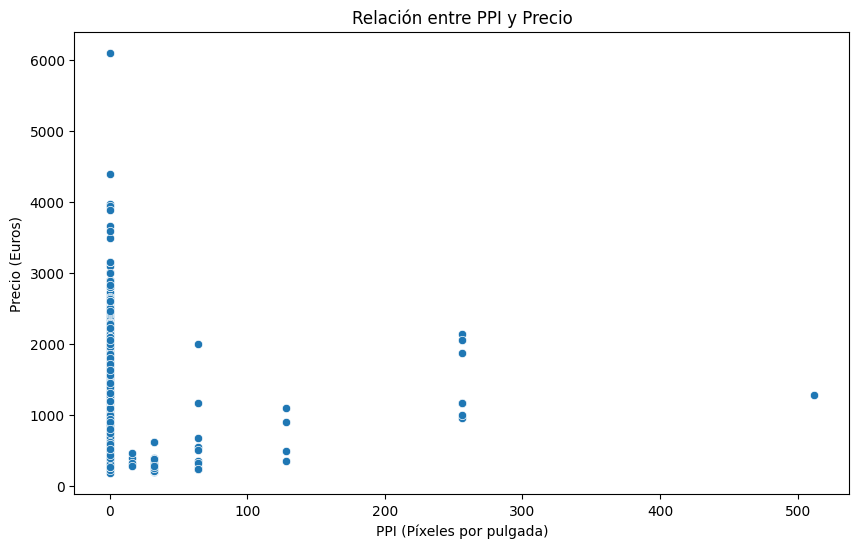

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gráfico de dispersión entre PPI y Precio
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Flash_Storage_GB', y='Price_in_euros')
plt.title('Relación entre PPI y Precio')
plt.xlabel('PPI (Píxeles por pulgada)')
plt.ylabel('Precio (Euros)')
plt.show()



In [ ]:
"""
X = df.drop(['Price_in_euros',"Weight","Inches","Ram"], axis=1)
y = df['Price_in_euros'].copy()
X.shape
"""

In [8]:
X = df.iloc[:,11:].copy()
y = df["Price_in_euros"].copy()

In [9]:
X.shape

(912, 13)

In [10]:
X.head()

,inches,ram_gb,weight_kg,Type_2 in 1 Convertible,Type_Gaming,Type_Netbook,Type_Notebook,Type_Ultrabook,Type_Workstation,SSD_GB,HDD_GB,Flash_Storage_GB,Hybrid_GB
755,15.6,8,1.86,False,False,False,True,False,False,256.0,0.0,0.0,0.0
618,15.6,16,2.59,False,True,False,False,False,False,0.0,1024.0,0.0,0.0
909,15.6,8,2.04,False,False,False,True,False,False,0.0,1024.0,0.0,0.0
2,13.3,8,1.34,False,False,False,False,True,False,0.0,0.0,128.0,0.0
286,15.6,4,2.25,False,False,False,True,False,False,0.0,1024.0,0.0,0.0


In [11]:
y.shape

(912,)

In [12]:
y.head()

755    539.00
618    879.01
909    900.00
2      898.94
286    428.00
Name: Price_in_euros, dtype: float64

### 2. Dividir X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [14]:
X_train

,inches,ram_gb,weight_kg,Type_2 in 1 Convertible,Type_Gaming,Type_Netbook,Type_Notebook,Type_Ultrabook,Type_Workstation,SSD_GB,HDD_GB,Flash_Storage_GB,Hybrid_GB
1118,17.3,8,3.00,False,False,False,False,False,True,0.0,1024.0,0.0,0.0
153,15.6,16,2.56,False,True,False,False,False,False,512.0,0.0,0.0,0.0
275,13.3,8,1.37,False,False,False,False,True,False,512.0,0.0,0.0,0.0
1100,14.0,4,1.54,False,False,False,True,False,False,0.0,500.0,0.0,0.0
131,17.3,16,2.80,False,False,False,True,False,False,256.0,2048.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,14.0,8,1.94,False,False,False,True,False,False,0.0,2048.0,0.0,0.0
996,15.6,6,2.20,False,False,False,True,False,False,256.0,0.0,0.0,0.0
770,12.5,16,1.18,False,False,False,False,True,False,256.0,0.0,0.0,0.0
407,15.6,4,2.20,False,False,False,True,False,False,0.0,1024.0,0.0,0.0


In [15]:
y_train

1118    2899.00
153     1249.26
275     1958.90
1100    1030.99
131     1396.00
         ...   
578      389.00
996      549.00
770     1859.00
407      306.00
418     1943.00
Name: Price_in_euros, Length: 729, dtype: float64

### 3. Baseline de modelos


In [16]:
dfmodel = RandomForestRegressor()

dfmodel.fit(X_train,y_train)

RandomForestRegressor()

In [17]:
y_pred=dfmodel.predict(X_test)

### 4. Sacar métricas, valorar los modelos 

Recuerda que en la competición se va a evaluar con la métrica de ``RMSE``.

In [18]:
RMSE = root_mean_squared_error(y_test,y_pred)
RMSE

400.97146438374676

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 1. Carga los datos de `test.csv` para predecir.


In [19]:
X_pred = pd.read_csv("data/test.csv", index_col=0)
X_pred.index.name = None
X_pred.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg
1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg
1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg
1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg
1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg


In [15]:
X_pred.tail()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
820,MSI,GE72MVR 7RG,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.9kg
948,Toshiba,Tecra Z40-C-12X,Notebook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.47kg
483,Dell,Precision M5520,Workstation,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia Quadro M1200,Windows 10,1.78kg
1017,HP,Probook 440,Notebook,14.0,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,Windows 10,1.64kg
421,Asus,ZenBook Flip,2 in 1 Convertible,13.3,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.27kg


In [20]:
X_pred["inches"]=X_pred.Inches.astype(float)
X_pred["ram_gb"]=X_pred["Ram"].str.replace("GB","").astype(int)
X_pred["weight_kg"]=X_pred["Weight"].str.replace("kg","").astype(float)
X_pred = pd.get_dummies(X_pred, columns=['TypeName'], prefix='Type')

In [21]:
import numpy as np
import pandas as pd

# Función para extraer el número de memoria y convertir a GB
def convert_to_gb(memory):
    # Extraemos el número de memoria, ignorando texto como 'GB', 'TB', etc.
    try:
        memory_value = ''.join([char for char in memory if char.isdigit() or char == '.'])
        memory_value = float(memory_value)
        # Si la unidad es TB, la convertimos a GB
        if 'TB' in memory:
            return memory_value * 1024  # 1 TB = 1024 GB
        else:
            return memory_value  # Si ya está en GB, lo dejamos como está
    except ValueError:
        return np.nan  # Si no se puede extraer un valor numérico, devolvemos NaN

# Función para procesar cada valor de la columna 'Memory' que pueda tener múltiples memorias
def process_memory(memory):
    ssd, hdd, flash, hybrid = 0, 0, 0, 0  # Inicializamos las variables de cada tipo de memoria

    # Separamos los valores si hay un '+'
    memories = memory.split(' + ') if isinstance(memory, str) else []
    
    for mem in memories:
        # Revisamos el tipo de memoria y aplicamos la conversión a GB
        if 'SSD' in mem:
            ssd += convert_to_gb(mem)
        elif 'HDD' in mem:
            hdd += convert_to_gb(mem)
        elif 'Flash Storage' in mem:
            flash += convert_to_gb(mem)
        elif 'Hybrid' in mem:
            hybrid += convert_to_gb(mem)

    return ssd, hdd, flash, hybrid

# Aplicamos la función para crear nuevas columnas
X_pred[['SSD_GB', 'HDD_GB', 'Flash_Storage_GB', 'Hybrid_GB']] = X_pred['Memory'].apply(lambda x: pd.Series(process_memory(x)))



In [22]:
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Company                  391 non-null    object 
 1   Product                  391 non-null    object 
 2   Inches                   391 non-null    float64
 3   ScreenResolution         391 non-null    object 
 4   Cpu                      391 non-null    object 
 5   Ram                      391 non-null    object 
 6   Memory                   391 non-null    object 
 7   Gpu                      391 non-null    object 
 8   OpSys                    391 non-null    object 
 9   Weight                   391 non-null    object 
 10  inches                   391 non-null    float64
 11  ram_gb                   391 non-null    int32  
 12  weight_kg                391 non-null    float64
 13  Type_2 in 1 Convertible  391 non-null    bool   
 14  Type_Gaming              391 

In [23]:
X_pred = X_pred.iloc[:,10:].copy()

 ## 2. Replicar el procesado para ``test.csv``

In [24]:
X_pred

,inches,ram_gb,weight_kg,Type_2 in 1 Convertible,Type_Gaming,Type_Netbook,Type_Notebook,Type_Ultrabook,Type_Workstation,SSD_GB,HDD_GB,Flash_Storage_GB,Hybrid_GB
209,15.6,16,2.400,False,True,False,False,False,False,512.0,0.0,0.0,0.0
1281,15.6,4,2.400,False,False,False,True,False,False,0.0,500.0,0.0,0.0
1168,15.6,4,1.900,False,False,False,True,False,False,0.0,1024.0,0.0,0.0
1231,15.6,8,2.191,True,False,False,False,False,False,256.0,0.0,0.0,0.0
1020,14.0,4,1.950,False,False,False,True,False,False,256.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,17.3,16,2.900,False,True,False,False,False,False,512.0,1024.0,0.0,0.0
948,14.0,4,1.470,False,False,False,True,False,False,128.0,0.0,0.0,0.0
483,15.6,8,1.780,False,False,False,False,False,True,256.0,0.0,0.0,0.0
1017,14.0,4,1.640,False,False,False,True,False,False,0.0,500.0,0.0,0.0


In [29]:
predictions_submit = dfmodel.predict(X_pred)
predictions_submit

array([1382.8486    ,  386.88911409,  416.39321429, 1117.99109243,
        736.82270833,  665.08878492,  962.63479524, 1006.02033333,
       1404.02055714,  311.87516667, 2393.39735   , 1808.02064921,
        493.86421889, 1910.3118    , 1092.33313333,  427.06438722,
       2235.96636667, 1467.43296667, 1585.9804    ,  672.93440339,
       1392.33213333,  322.09      ,  717.12833333, 1817.0355    ,
        482.7832    ,  580.41330562,  700.05166667,  729.2583    ,
       2374.67699   , 1080.86377167, 1872.67125048,  372.05748227,
        686.66347857, 3068.40976667, 2029.28002619, 1985.89463547,
        547.26132768, 1589.64373333,  886.43728333, 1547.39566667,
        810.81195   ,  852.45475   ,  572.47163333, 1080.86377167,
       1152.60528333, 1169.08473333, 1003.45454444,  474.7807274 ,
        871.39213333,  452.60440476, 2153.4346    ,  580.41330562,
       1200.8841381 ,  700.8775    , 1690.46426667, 1840.7885    ,
        548.97149846,  862.31783333,  952.8397    ,  649.83315

**¡OJO! ¿Por qué me da error?** 

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [ ]:
# ¿Qué opináis?
# ¿Sí, no?

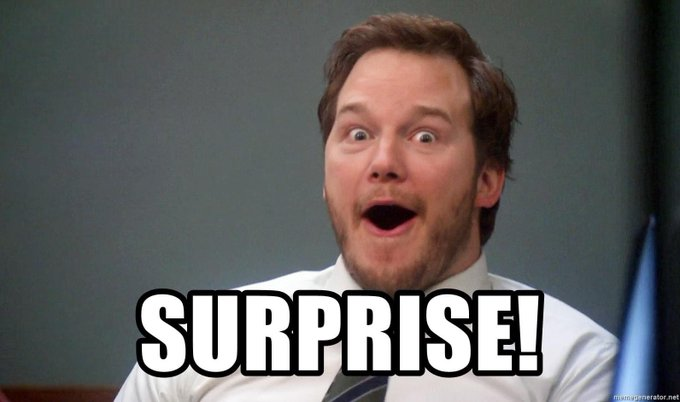

### 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [30]:
sample = pd.read_csv("data/sample_submission.csv")

In [31]:
sample.head()

,laptop_ID,Price_in_euros
0,209,1949.1
1,1281,805.0
2,1168,1101.0
3,1231,1293.8
4,1020,1832.6


In [32]:
sample.shape

(391, 2)

### 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [33]:
#¿Cómo creamos la submission?
submission = pd.DataFrame({"laptop_ID":X_pred.index,"Price_in_euros":predictions_submit})

In [32]:
submission.head()

,laptop_ID,Price_in_euros
0,209,1578.344183
1,1281,410.605562
2,1168,492.988458
3,1231,819.210277
4,1020,1078.327500


In [34]:
submission.shape

(391, 2)

### 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [35]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto del TA: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `test.csv`. Lloro.")

In [36]:
chequeador(submission)

You're ready to submit!
